# (11.3B) Application of filter with new distance - transcription rate volume dependence

In this notebook we use the new objective function $D_{new} = D_{HD}\times D_{euc}$ in combination with the averaging filter designed in notebook 10. The filter width will be chosen so that the autocorrelation function of the artificial experimental lineage is $1/e$.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## Second attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\alpha_0 = 5.0$, $\alpha_1 = 0.0$, $\beta_0 = 1.0$ and $\beta_1 = 1.0$:

In [4]:
true_par = [0.5,1.0,0.0,0.000001];

In [5]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_c, ssa[2][:]);
    end
    return convert(Array{Array{Float64,1},1},SSA_data_c) # return 
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [6]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1]);

Let's plot this data:

In [7]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings, StatsBase, Statistics, LinearAlgebra; pyplot()

Plots.PyPlotBackend()

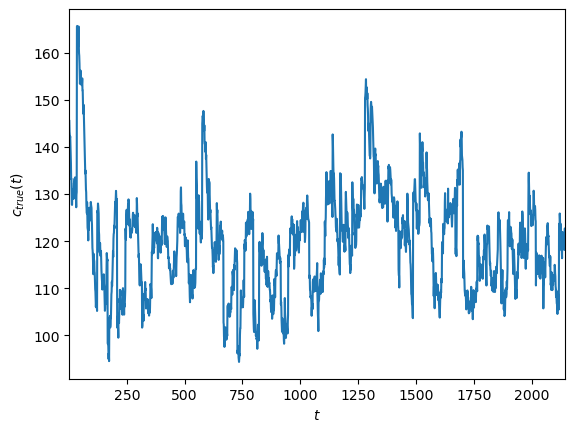

In [8]:
PyPlot.plot(range(1,length(vcat(expt_ssa_conc...)[:]),step=1),vcat(expt_ssa_conc...)[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(vcat(expt_ssa_conc...)[:])]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.


0.9899999999999999

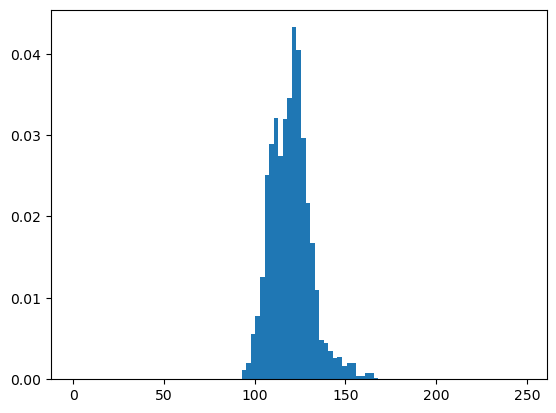

In [9]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(vcat(expt_ssa_conc...)[:])*1.5, 100);
true_bin_vals, other_stuff = ax.hist(vcat(expt_ssa_conc...)[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals*(maximum(vcat(expt_ssa_conc...)[:])*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

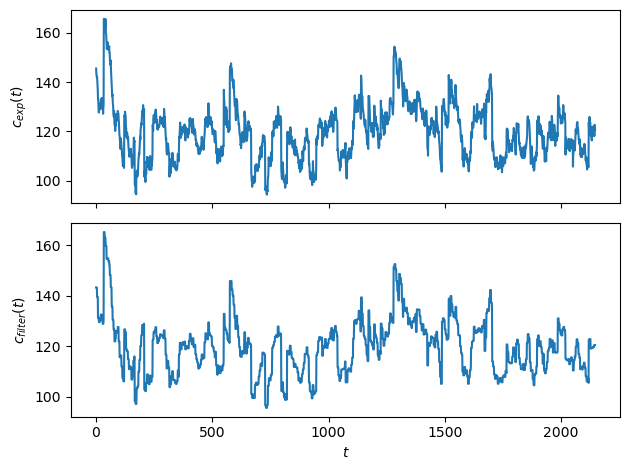

In [10]:
n = 4;

lin_expt = vcat(expt_ssa_conc...); filter_expt = filter_lin(expt_ssa_conc, n)[2]
filter_expt_form = hcat(filter_expt);

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{filter}(t)"); 
axs[1].plot(range(1,length(lin_expt),step=1),lin_expt); axs[2].plot(range(1,length(filter_expt),step=1),filter_expt);

In [11]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = filter_lin(Single_lin(lineage_data, var_params, lin_ic)[:], n)[2] # choose up-sep form [2]
    return hcat(lin_conc)::Array{Float64,2}
end

simulator_function_conc (generic function with 1 method)

Create the new distance function that takes in the sample trajectory vector and experimental trajectory as inputs and outputs the product of the hellinger distance and the euclidean distance between the two trajectories.

In [12]:
function new_distance(samp_traj::Array{Float64,1}, exp_traj::Array{Float64,1})
    euc_dist = euclidean(samp_traj[:], exp_traj[:]); # euclidean distance
    samp_bins = normalize(fit(Histogram, samp_traj[:], mod_bins), mode=:probability).weights;
    exp_bins = normalize(fit(Histogram, exp_traj[:], mod_bins), mode=:probability).weights;
    hell_dist = hellinger(samp_bins, exp_bins); # HD
    
    return euc_dist*hell_dist::Float64 # return the product
end

new_distance (generic function with 1 method)

In [13]:
thres_cutoff = sum(new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:]) for i in 1:1000)/1000

50.456205748543326

In [14]:
@time new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:])

  0.005770 seconds (29.62 k allocations: 2.614 MiB)


42.536891398626224

┌ Info: GpABC rejection simulation. ϵ = 250.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 76/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 165/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 252/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 341/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 427/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 150.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 70/1000 particles.

┌ Info: GpABC SMC simulation accepted 250/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 286/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 316/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 355/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 391/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 427/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 463/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 498/14000 particles.
└ @ GpABC /home/s1402978/.j

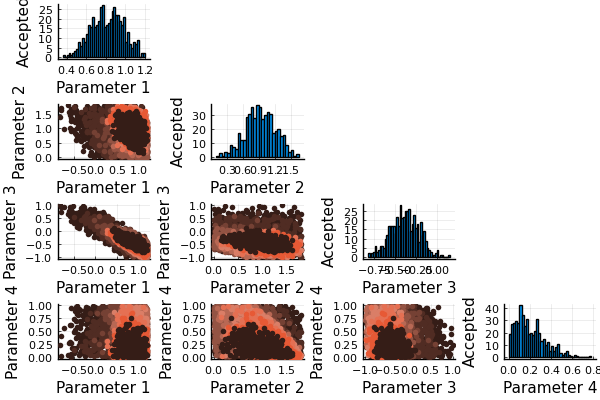

In [15]:
n_particles = 500;
threshold_schedule = [250.0, 150.0, 100.0, 90.0, 80.0, 70.0, 65.0, 60.0, 55.0];

priors = [Uniform(-1.0,1.0), Uniform(0.0, 1.8), Uniform(-1.0,1.0),
          Uniform(0.0, 1.0)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935"]#,"#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [16]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  0.819263946109949
  0.9195264853077207
 -0.3800264870994937
  0.17219819420076551

In [17]:
true_par

4-element Array{Float64,1}:
 0.5
 1.0
 0.0
 1.0e-6

Print the differences.

In [18]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
  0.319263946109949
 -0.08047351469227926
 -0.3800264870994937
  0.1721971942007655

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

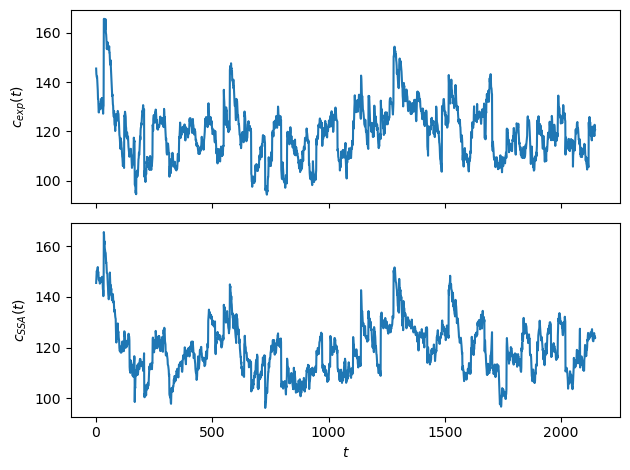

  0.014318 seconds (42.37 k allocations: 3.945 MiB)


In [19]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(expt_ssa_conc...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

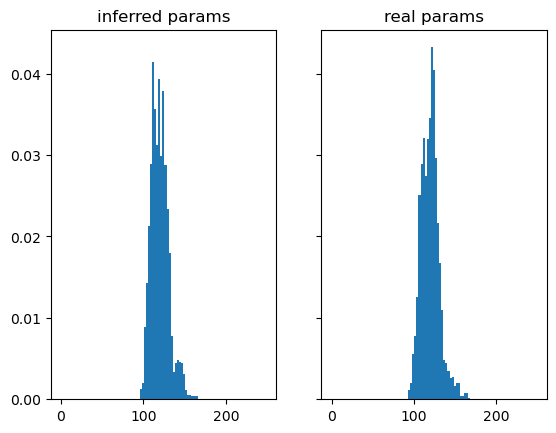

Hellinger distance between these is: 0.09431087831024719

In [20]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

## Run them again!

┌ Info: GpABC rejection simulation. ϵ = 250.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 93/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 176/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 257/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 336/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 425/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 150.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 67/1000 particles.

┌ Info: GpABC SMC simulation accepted 89/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 130/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 160/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 202/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 233/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 274/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 311/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 340/10000 particles.
└ @ GpABC /home/s1402978/.julia/

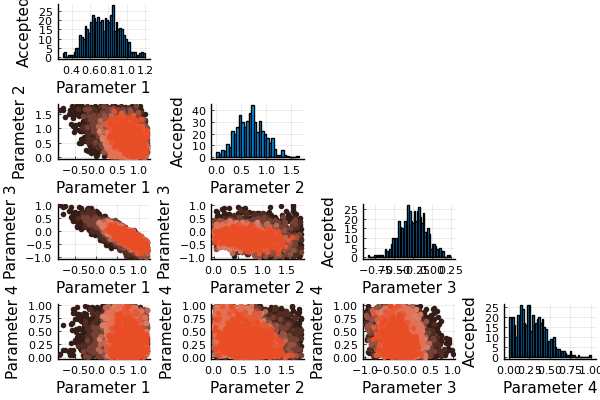

In [21]:
n_particles = 500;
threshold_schedule = [250.0, 150.0, 100.0, 90.0, 80.0, 70.0, 65.0, 60.0, 55.0];

priors = [Uniform(-1.0,1.2), Uniform(0.0, 1.8), Uniform(-1.0,1.0),
          Uniform(0.0, 1.0)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

In [22]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  0.7537635070942015
  0.674730144602995
 -0.23787076076030844
  0.2551680220643151

In [23]:
true_par

4-element Array{Float64,1}:
 0.5
 1.0
 0.0
 1.0e-6

Print the differences.

In [24]:
diff_2 = (pars_conc_2 - true_par)

4-element Array{Float64,1}:
  0.2537635070942015
 -0.32526985539700504
 -0.23787076076030844
  0.25516702206431513

┌ Info: GpABC rejection simulation. ϵ = 250.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 78/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 160/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 245/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 321/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 406/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 500/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulat

┌ Info: GpABC SMC simulation accepted 296/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 354/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 405/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 456/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 55.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 53/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 99/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 156/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/s

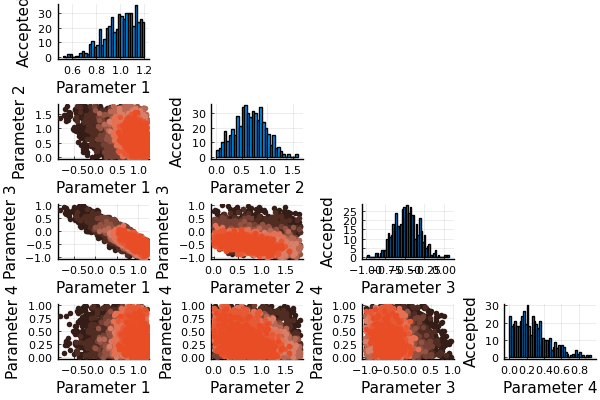

In [25]:
n_particles = 500;
threshold_schedule = [250.0, 150.0, 100.0, 90.0, 80.0, 70.0, 65.0, 60.0, 55.0];

priors = [Uniform(-1.0,1.2), Uniform(0.0, 1.8), Uniform(-1.0,1.0),
          Uniform(0.0, 1.0)];

sim_abcsmc_res_conc_3 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3, population_colors=population_colors)

In [26]:
pars_conc_3 = [median(sim_abcsmc_res_conc_3.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
  1.0181137310982395
  0.6548742766670919
 -0.48095426427645915
  0.23356003771611014

In [27]:
true_par

4-element Array{Float64,1}:
 0.5
 1.0
 0.0
 1.0e-6

Print the differences.

In [28]:
diff_3 = (pars_conc_3 - true_par)

4-element Array{Float64,1}:
  0.5181137310982395
 -0.34512572333290814
 -0.48095426427645915
  0.23355903771611014

## Summary of results

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$ and degradation rate $d = 0$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Let's see the inferred medians of the posterior distributions in some tables.

In [29]:
using DataFrames;

In [30]:
par_conc = convert(Array{Float64,2},transpose([true_par pars_conc_1 pars_conc_2 pars_conc_3]));
df_conc = DataFrame(alpha_0 = 10.0 .^par_conc[:,1], alpha_1 = par_conc[:,2], beta_0 = 10.0 .^par_conc[:,3], beta_1 = par_conc[:,4]);

In [31]:
df_conc

,alpha_0,alpha_1,beta_0,beta_1
,Float64,Float64,Float64,Float64
1,3.16228,1.0,1.0,1.0e-6
2,6.59575,0.919526,0.416844,0.172198
3,5.67236,0.67473,0.578268,0.255168
4,10.4259,0.654874,0.330404,0.23356
